# Stochastic Normalizing Flows for Lattice Field Theory
Simple implementation of the Stochastic Normalizing Flows used in: <a href="https://link.springer.com/article/10.1007/JHEP07(2022)015">Stochastic Normalizing Flows as non equilibrium transformations</a>

Tutorial on standard Normalizing Flows: [Introduction to Normalizing Flows for Lattice Field Theory](https://arxiv.org/abs/2101.08176)


If this code is helpful for your research, please cite us:
```
@article{caselle2022stochastic,
  title={Stochastic normalizing flows as non-equilibrium transformations},
  author={Caselle, Michele and Cellini, Elia and Nada, Alessandro and Panero, Marco},
  journal={Journal of High Energy Physics},
  volume={2022},
  number={7},
  pages={1--31},
  year={2022},
  publisher={Springer}
}
```



In [ ]:
from IPython.display import display
import gc
import base64
import io
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import gc
from scipy.special import logsumexp
import math

In [ ]:
if torch.cuda.is_available():
    torch_device = 'cuda'
    float_dtype = np.float32 # single
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch_device = 'cpu'
    float_dtype = np.float64 # double
    torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")


TORCH DEVICE: cuda


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [ ]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


In [ ]:
#Utility taken from https://arxiv.org/abs/2101.08176
def grab(var):
    if torch.is_tensor(var):
        return var.detach().cpu().numpy()
    else:
        return var

def init_live_plot(nstep, dpi=125, figsize=(8,4)):
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, nstep)
    plt.ylim(0, 1)

    ess_line = plt.plot([0],[0], alpha=0.5) # dummy
    plt.grid(False)
    plt.ylabel('ESS')

    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss')

    plt.xlabel('Epoch')

    display_id = display(fig, display_id=True)

    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )

def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

def print_metrics(history, era, epoch, avg_last_N_epochs):
    print(f'== Era {era} | Epoch {epoch} metrics ==')
    for key, val in history.items():
        avgd = np.mean(val[-avg_last_N_epochs:])
        print(f'\t{key} {avgd:g}')

Target theory with action:
$$S[\phi]=\sum_{x\in\Lambda}-2\kappa \sum_{\mu=1,2}\phi(x)\phi(x+\hat{\mu})+(1-2\lambda)\phi(x)^2+\lambda\phi(x)^4$$

In [ ]:
class ScalarPhi4Action:
    def __init__(self, kappa, lam, phi2coeff=0):
        self.kappa = kappa
        self.lam = lam
        self.dims = range(1,3)
        if (phi2coeff == 0):
            self.phi2coeff = (1.0 - 2.0 * self.lam)
        else:
            self.phi2coeff = phi2coeff
        self.info='_ScalarPhi4_kappa='+str(kappa)+'_lambda='+str(lam)

    def __call__(self, cfgs, protocol=[1.,1.,1.]):
        return torch.sum(self.action_density(cfgs), dim=tuple(self.dims))

    def action_density(self, cfgs, protocol=[1.,1.,1.]):
        return self.phi2term(cfgs) + self.phi4term(cfgs) + self.kineticterm(cfgs)

    def phi2term(self, cfgs):
        return self.phi2coeff * cfgs**2

    def phi4term(self, cfgs):
        return self.lam * cfgs**4

    def kineticterm(self, cfgs):
        action_density = cfgs * (torch.roll(cfgs, 1, 1) + torch.roll(cfgs, 1, 2))
        return -2.0 * self.kappa * action_density

    def local_kineticterm(self, cfgs):
        return -2.0 * self.kappa * self.nearest_neighbours_sum(cfgs)

    def nearest_neighbours_sum(self, cfgs):
        return torch.roll(cfgs, 1, 1) + torch.roll(cfgs, -1, 1) + torch.roll(cfgs, 1, 2) + torch.roll(cfgs, -1, 2)

    def delta_local_action(self, x_active, x_frozen, delta, protocol=[1.,1.,1.]):
        delta_act = self.phi2term(x_active + delta) - self.phi2term(x_active)
        delta_act += self.phi4term(x_active + delta) - self.phi4term(x_active)
        delta_act -= 2.0 * self.kappa * delta * self.nearest_neighbours_sum(x_frozen)
        return delta_act


Prior distribution:
$$q_0(z)=\frac{1}{Z_0}e^{-\sum_i^{|\Lambda|} \frac{1}{2\sigma^2} z_i^2}$$
where $Λ$ is a square lattice of size $N_t\times N_r$

In [ ]:
class SimpleNormal(ScalarPhi4Action):
    def __init__(self, loc, stand_dev):
        ScalarPhi4Action.__init__(self, kappa=0.,lam=0.,phi2coeff=1./(2*stand_dev**2))
        self.dist = torch.distributions.normal.Normal(loc, torch.ones_like(loc) * stand_dev)
        self.dist_loc = torch.distributions.normal.Normal(0.0, stand_dev)
        self.sd = stand_dev
        self.logz0_loc = np.log(stand_dev * np.sqrt(2*np.pi))
        self.logz0 = len(torch.flatten(loc)) * self.logz0_loc

        self.lam = 0
        self.kappa = 0
        self.phi2coeff = 1.0 / (2.0 * self.sd**2)

    def log_prob(self, x):
        logp = self.dist.log_prob(x)
        return torch.sum(logp, dim=(1,2))

    def sample_n(self, batch_size):
        x = self.dist.sample((batch_size,))
        return x

The following class is used to compute the action $S_{\eta_i}$, the protocol which interpolates between the prior and the target theory

In [ ]:
class ActionProtocolPhi4:
    def __init__(self, action0, action1):
        self.dims = range(1,3)
        self.action0 = action0
        self.action1 = action1
        self.N_protocol_par=3
    def __call__(self, cfgs, protocol):
        return torch.sum(self.action_density(cfgs, protocol), dim=tuple(self.dims))

    def action_density(self, cfgs, protocol):
        act = self.phi2coeff(protocol[0]) * cfgs**2 + self.phi4coeff(protocol[1]) * cfgs**4 + self.kincoeff(protocol[2]) * cfgs * (torch.roll(cfgs, 1, 1) + torch.roll(cfgs, 1, 2))
        return act

    def phi2coeff(self, protocol0):
        return protocol0 * self.action1.phi2coeff + (1.0 - protocol0) * self.action0.phi2coeff

    def phi4coeff(self, protocol1):
        return protocol1 * self.action1.lam + (1.0 - protocol1) * self.action0.lam

    def kincoeff(self, protocol2):
        return -2.0 * (protocol2 * self.action1.kappa + (1.0 - protocol2) * self.action0.kappa)

    def phi4term(self, cfgs, protocol1):
        act = self.phi4coeff(protocol1) * cfgs**4
        return act

    def local_kineticterm(self, cfgs, protocol2):
        act = self.kincoeff(protocol2) * self.action1.nearest_neighbours_sum(cfgs)
        return act

    def delta_local_action(self, x_active, x_frozen, delta, protocol):
        delta_act = self.phi2coeff(protocol[0]) * ((x_active + delta)**2 - (x_active)**2)
        delta_act += self.phi4coeff(protocol[1]) * ((x_active + delta)**4 - (x_active)**4)
        delta_act += self.kincoeff(protocol[2]) * delta * self.action1.nearest_neighbours_sum(x_frozen)

        return delta_act

Building block for the affine convolutional coupling layer, see https://arxiv.org/abs/2101.08176

In [ ]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_tanh=False, use_bias=False):
    '''
    Convolutional Neural Netowrk
    hiddens_sizes=[N_filters for hidden layer 1, .... ,N_filters for hidden layer n]
    num hidden layers = len(hidden_sizes)
    '''
    sizes = [in_channels] + hidden_sizes + [out_channels]

    padding_size = (kernel_size // 2)
    net = []
    for i in range(len(sizes) - 1):
        conv = torch.nn.Conv2d(sizes[i], sizes[i+1], kernel_size, padding=padding_size, stride=1, padding_mode='zeros', bias=use_bias)
        #torch.nn.init.xavier_normal_(conv.weight, gain=torch.nn.init.calculate_gain('tanh'))
        #torch.nn.init.normal_(conv.weight, std=0.01)
        net.append(conv)
        if i != len(sizes) - 2:
            if (use_tanh):
                net.append(torch.nn.Tanh())
            else:
                net.append(torch.nn.LeakyReLU(0.1))
    net[-1].weight.data.zero_()
    if use_bias:
        net[-1].bias.data.zero_()
    net.append(torch.nn.Tanh())
    return torch.nn.Sequential(*net)


class AffineCoupling(torch.nn.Module):
    '''
    RealNVP coupling layer
    '''
    def __init__(self, net, *, mask_shape, mask_parity, z2_equiv=True):
        super().__init__()
        self.mask = make_checker_mask(mask_shape, mask_parity)
        self.net = net
        self.z2_equiv=z2_equiv

    def forward(self, x):
        x_frozen = self.mask * x
        x_active = (1 - self.mask) * x

        net_out = self.net(x_frozen.unsqueeze(1)).squeeze(1)
        scale, shift = net_out[:,0], net_out[:,1]

        if (self.z2_equiv):
            s = (1 - self.mask) * torch.abs(scale)
        else:
            s = (1 - self.mask) * scale
        t = (1 - self.mask) * shift

        fx = (x_active * torch.exp(-s) - t) + x_frozen
        axes = range(1,len(s.size()))
        logJ = torch.sum(-s, dim=tuple(axes))
        return fx, logJ


def make_coupling_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size,z2_equiv=True):
    if z2_equiv:
        bias=False
        tanh=True
    else:
        bias=True
        tanh=False
    layers = []
    if (n_layers > 0):
        for i in range(n_layers):
            parity = i % 2
            net = make_conv_net(in_channels=1, out_channels=2, hidden_sizes=hidden_sizes, kernel_size=kernel_size, use_tanh=tanh, use_bias=bias)
            coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity, z2_equiv=z2_equiv)
            layers.append(coupling)

    return torch.nn.ModuleList(layers)


def make_checker_mask(shape, parity):
    checker = torch.ones(shape, dtype=torch.uint8) - parity
    checker[::2, ::2] = parity
    checker[1::2, 1::2] = parity
    return checker


## Stochastic Normalizing Flows

The second main ingredient of Stochastic Normalizing Flows are is the NE-MCMC algorithm, wich main idea is to exploit the Jarzynski equality:
$$\frac{Z_{\eta_N}}{Z_{\eta_{0}}}=\langle e^{-W}\rangle_f$$

in order to compute the partition function of the generated samples knowing the density of the prior $q_0$, the target un-normalized density $S_{\eta_N}$ and the heat $Q$ of the transformation:
$$W(\phi)=S_{\eta_{N}}[\phi_N]-S_{\eta_{0}}[\phi_0]-Q(\phi_0,\phi_1,...,\phi_N)$$
$$Q=\sum_{i=1}^{N-1}\{S_{\eta_{i+1}}[\phi_{i+1}]-S_{\eta_{i+1}}[\phi_{i}]\}$$

The update used to implement the stochastic layer is the heatbath algorithm.

In the case of Stochastic Normalizing Flows, we interlive stocastic updates with Normalizing Flows coupling layers:
$$Z_{\eta_N}=\langle e^{-w}\rangle_f$$
where
$$W=S_{\eta_N}[\phi_N]+\ln q_0 (\phi_0)-\ln|\det J_g|-Q(\phi_0,\phi_1,...,\phi_N)$$
with $\ln|\det J_g|$ sum of the log determinat of the Jacobian of the normalizing flow layers.


### Heatbath
If we want to generate a new configuration in Markov chain, we can update the lattice by applying a given algorithm one site $\phi(x)$ at a time, leaving all the other sites fixed. In this way we perform a so-called sweep of the lattice sites. Since the action contains only nearest-neighbour interaction, one can apply the algorithm for all the even sites (leaving the odd ones fixed) and then the other way around. This is convenient on hardware such as GPUs where it is better to perform as many concurrent operations as possible.
The action terms that involve the site $\phi(x)$ look like this:
$$S_{loc}(x)=-2\kappa \sum_{\mu=-2,-1,1,2,}\phi(x)\phi(x+\hat{\mu})+(1-2\lambda)\phi(x)^2+\lambda\phi(x)^4=A\phi(x)+B\phi(x)^2+C\phi(x)^4$$
where A, B and C are fixed coefficients. Of course A depends on the four nearest neighbours, but these are left fixed in the update of $\phi(x)$. The rest of the action is unchanged and we can ignore it.
The goal here is to propose a new $\phi'$ from the Boltzmann distribution
$$p(\phi(x))\sim \exp(-S_{loc}[\phi])=\exp(-A\phi(x)-B\phi(x)^2-C\phi(x)^4)$$
using a heatbah algorithm. The general details are contained in Chapter 7 of the [Montvay-Muenster book](https://www.cambridge.org/core/books/quantum-fields-on-a-lattice/4401A88CD232B0AEF1409BF6B260883A) on Lattice QCD, as well as a detailed description of the SU(2) gauge theory case.

It is remarkably simple to generate a distribution very similar to p: it is simply a shifted normal distribution
$$p_0(\phi(x))\sim \exp(−A\phi − B\phi^2) \sim exp(−By^2)$$
with $\phi=y-\frac{A}{2B}$. One simply samples y from a normal distribution and then calculates $\phi$.
However, this is not the correct distribution: this proposal for the new value of $\phi$ needs an accept-reject step to take into account the remaining part of the action, that is the $\exp(−C\phi^4)$ extra factor in the probability distribution. We do so by accepting/rejecting the proposal with a probability

$$\min\biggl( 1,\frac{p(\phi)}{p_0(\phi)}\biggr) =\min\biggl( 1,\exp(−C\phi^4)\biggr)$$

In principle one should repeat the proposal + accept/reject steps until a valid candidate is accepted. It is more common to set a maximum number of iterations M to avoid getting stuck on a particular value. If the proposal is rejected M times, the old $\phi(x)$ remains unchanged. Interestingly, M can be as low as 1 without compromising the essential properties of the algorithm. This is the strategy adopted in this code, in order to improve the efficiency on a GPU, where many concurrent operations are to be preferred than repeating the accept-reject step on a subset of sites. The actual, most efficient value of M depends also on the values of $x$ and $\lambda$.


In [ ]:
class MonteCarloUpdate(torch.nn.Module):
    def __init__(self, lattice_shape, action_protocol, protocol_pars, nsteps=1, device='cuda'):
        super().__init__()

        self.pars=protocol_pars

        self.nsteps = nsteps #Numbers of stochastic updates for one stochastic layer

        self.action_protocol = action_protocol
        self.N_pars=action_protocol.N_protocol_par
        self.action_density = action_protocol.action_density


        self.update = self.local_heatbath
        self.heatbathSd = 1.0 / np.sqrt(2.0 * self.action_protocol.phi2coeff(self.pars[0]))
        self.norm_dist = torch.distributions.normal.Normal(torch.zeros(lattice_shape), self.heatbathSd)
        self.unif_dist = torch.distributions.uniform.Uniform(torch.zeros(lattice_shape), torch.ones(lattice_shape))

        self.even_mask = make_checker_mask(lattice_shape, 0)
        self.odd_mask = make_checker_mask(lattice_shape, 1)

        self.device = device

    def heatbath(self, x_active, x_frozen, norm_rn, unif_rn):
        nn_sum = self.action_protocol.local_kineticterm(x_frozen, self.pars[2])
        shift = - self.heatbathSd**2 * nn_sum

        #only one proposal: in principle one could generate a new proposal for not-accepted configurations until they are all accepted
        #very inefficient on GPUs
        x_active_new = norm_rn + shift
        accepted = torch.exp(-self.action_protocol.phi4term(x_active_new, self.pars[1])) > unif_rn
        x_active = x_active * ~accepted + x_active_new * accepted
        return x_active


    def local_heatbath(self, x):
        S_old = self.action_density(x, self.pars)

        for n in range(self.nsteps):

            if self.device == 'cuda':
                norm_rn = torch.cuda.FloatTensor(x.shape).normal_(0.0, self.heatbathSd)
                unif_rn = torch.cuda.FloatTensor(x.shape).uniform_(0.0, 1.0)
            else:
                norm_rn = self.norm_dist.sample((x.shape[0],))
                unif_rn = self.unif_dist.sample((x.shape[0],))

            x_odd = x * self.odd_mask
            x_even = x * self.even_mask
            x_even = self.heatbath(x_even, x_odd, norm_rn * self.even_mask, unif_rn * self.even_mask)
            x_odd = self.heatbath(x_odd, x_even, norm_rn * self.odd_mask, unif_rn * self.odd_mask)

            x = x_even + x_odd

        S = self.action_density(x, self.pars)
        dQ = torch.sum(S - S_old, dim=(1,2))

        return x, dQ

    def forward(self, x):
        x, dQ = self.update(x)

        return x, dQ

def make_stochastic_layers(*, layers, action_protocol, nsteps, lattice_shape, dl_per_sg=2, sl_per_sg=1, input_protocol=None, device='cuda'):
    N_protocol_par=action_protocol.N_protocol_par
    if len(layers)==0:
        n_stoch_groups = 1
        n_stoch_layers = sl_per_sg
        dl_per_sg = 0
    elif dl_per_sg==0:
        n_stoch_groups = 1
        n_stoch_layers = n_stoch_groups * sl_per_sg
    else:
        n_layers = len(layers)
        #how many deterministic layers per stochastic layer
        #dl_per_sg must be even and a factor of n_layers
        n_stoch_groups = n_layers//dl_per_sg
        n_stoch_layers = n_stoch_groups * sl_per_sg

    for i in range(n_stoch_groups):
        pos = (i+1)*dl_per_sg + i*sl_per_sg
        for j in range(sl_per_sg):
            if (input_protocol is None):
                protocol_par = (i*sl_per_sg + j + 1)/n_stoch_layers
                protocol_pars=np.ones(N_protocol_par)*protocol_par
            elif input_protocol=='non-smooth':
                protocol_par = (pos + 1)/(n_layers + n_stoch_layers)
                protocol_pars=np.ones(N_protocol_par)*protocol_par
            else:
                protocol_pars=input_protocol[i+1]

            coupling = MonteCarloUpdate(lattice_shape, action_protocol, protocol_pars, nsteps=nsteps, device=device)
            layers.insert(pos, coupling)
            pos += 1
    return torch.nn.ModuleList(layers)



## Stochastic Normalizing Flows
The following class can be used to build Normalizing Flows (stochastic=False), Stochastic Evolution (stochastic=True, n_layers=0) and Stochastic Normalizing Flows (stochastic=True, n_layers>0).

In [ ]:
class Flow:
    def __init__(self, prior, action, lattice_shape, n_layers, hidden_sizes, kernel_size=3, z2_equiv=True,
                 stochastic=False, protocol_action=None, dl_per_sg=2, sl_per_sg=1, MCnsteps=1, input_protocol=None,
                device  = 'cuda'):
        self.prior = prior
        self.lattice_shape = lattice_shape
        self.history = {'loss' : [], 'loss_var' : [], 'ess' : [], 'logZ' : []}
        self.z2_equiv = z2_equiv
        self.kernel_size = kernel_size
        self.action=action

        self.layers = make_coupling_layers(z2_equiv=z2_equiv, lattice_shape=lattice_shape, n_layers=n_layers, hidden_sizes=hidden_sizes, kernel_size=kernel_size)

        if stochastic:
            self.layers = make_stochastic_layers(layers=self.layers, action_protocol=protocol_action, dl_per_sg=dl_per_sg, nsteps=MCnsteps,
                                                 lattice_shape=lattice_shape, sl_per_sg=sl_per_sg, input_protocol=input_protocol, device=device)


        self.device = device
        if device == 'cuda':
            self.layers.to(device)

    def __call__(self, batch_size):
        z = self.prior.sample_n(batch_size).to(self.device)
        logq = self.prior.log_prob(z)
        x, Q = self.apply_flow(z, self.layers, batch_size = batch_size)
        return x, logq, Q

    def apply_flow(self, z, coupling_layers, *, batch_size):
        Q = torch.zeros(batch_size)
        i = 0
        x = z
        for layer in coupling_layers:
            x, dQ, = layer.forward(x)
            Q = Q + dQ
            i = i + 1
        return x, Q

    def compute_metrics(self, w):
        loss = w.mean()
        w_np = grab(w)
        loss_var = w_np.var()
        N = len(w_np)
        logZ = logsumexp(-w_np)
        log_ess = 2.0 * logZ - logsumexp(-2 * w_np)
        ess_per_cfg = np.exp(log_ess) / N
        logZ = logZ - np.log(N)

        return loss, loss_var, ess_per_cfg, -logZ

    def print_metrics(self, era, epoch, avg_last_N_epochs, t0):

        print(f'== Era {era} | Epoch {epoch} metrics ==')
        for key, val in self.history.items():
            avgd = np.mean(val[-avg_last_N_epochs:])
            print(f'\t{key} {avgd:g}')
        print(time.time()-t0)


    def compile(self, base_lr=.001,patience=500, factor=0.92):
        self.optimizer = torch.optim.Adam(self.layers.parameters(), lr=base_lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', factor=factor, patience=patience, min_lr=1e-07, verbose=True)


    def train_step(self, batch_size, use_crooks=False):
        self.optimizer.zero_grad()

        x, logq, Q = self(batch_size=batch_size)

        act = self.action(x)
        w = act + logq - Q
        loss, loss_var, ess, logZ = self.compute_metrics(w)

        loss.backward()

        self.optimizer.step()
        self.scheduler.step(loss)

        self.history['loss'].append(grab(loss))
        self.history['loss_var'].append(grab(loss_var))
        self.history['ess'].append(grab(ess))
        self.history['logZ'].append(grab(logZ))


    def fit(self, *, N_era, N_epoch, batch_size, verbose=True, live=True):

        print(' N_era=' + str(N_era) + '\n N_epoch=' + str(N_epoch) + '\n batch_size=' + str(batch_size) + '\n')

        if live:
            [plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
            live_plot = init_live_plot(N_era*N_epoch)

        t0=time.time()
        for era in range(N_era):
            for epoch in range(N_epoch):
                self.train_step(batch_size)
                if verbose:
                    if epoch % N_epoch == 0:
                        self.print_metrics(era, epoch, avg_last_N_epochs=N_epoch, t0=t0)
                if live:
                    if epoch % 1 == 0:
                        update_plots(self.history, **live_plot)


        print('Last learning rate = ' + str(self.scheduler._last_lr))

        return self.history



Simple test of the training of Stochastic Normalizing Flows:

AffineCoupling(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Tanh()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Tanh()
    (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): Tanh()
  )
)
AffineCoupling(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Tanh()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Tanh()
    (4): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): Tanh()
  )
)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


 N_era=1000
 N_epoch=10
 batch_size=100



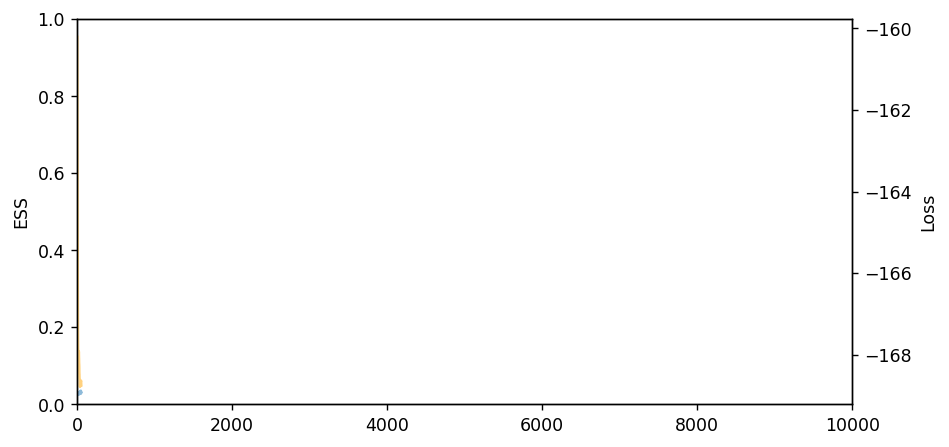

== Era 0 | Epoch 0 metrics ==
	loss -148.762
	loss_var 31.5444
	ess 0.034992
	logZ -156.333
0.46685361862182617
== Era 1 | Epoch 0 metrics ==
	loss -158.613
	loss_var 19.8608
	ess 0.0253649
	logZ -166.764
3.4578607082366943
== Era 2 | Epoch 0 metrics ==
	loss -167.809
	loss_var 13.7673
	ess 0.0261465
	logZ -173.633
5.732755184173584
== Era 3 | Epoch 0 metrics ==
	loss -167.844
	loss_var 13.3737
	ess 0.0289528
	logZ -174.146
8.063147783279419
== Era 4 | Epoch 0 metrics ==
	loss -168.527
	loss_var 14.1394
	ess 0.0329505
	logZ -174.695
10.351672649383545
== Era 5 | Epoch 0 metrics ==
	loss -168.708
	loss_var 13.7947
	ess 0.0301059
	logZ -174.704
12.560707807540894
== Era 6 | Epoch 0 metrics ==
	loss -168.627
	loss_var 13.1734
	ess 0.0340949
	logZ -174.393
15.29367470741272


In [ ]:
Ns = 16  #Spatial extension
Nt = 16 #Temporal extension
lattice_shape = (Nt,Ns)
n_layers = 24   #number of affine coupling layers ( 1 affine block=2 affine coupling layers)
hidden_sizes = [32,32] #hidden size of the convolutional network (we are using just the output layers)
kernel_size = 3  #Kernel size
N_era = 1000     #one Era correspond to N epoch
N_epoch = 10    #Numbers of gradient updates for one Era
batch_size = 100 #batch size for one epoch
base_lr = .0001 #initial learning rate
sl_per_sg = 1 # # of stochastic layer for stochastic group / #of steps of SE when n_layers=0


#target action
k=0.27
lam=0.022
action=ScalarPhi4Action(k,lam)
#prior
sd=math.sqrt(1.0/(4.0*lam+2))
prior = SimpleNormal(torch.zeros(lattice_shape),sd)
#protocol action
protocol_action=ActionProtocolPhi4(prior,action)
#flow class
flow=Flow(stochastic=False, sl_per_sg=sl_per_sg, MCnsteps=1, dl_per_sg=2,
          prior=prior, lattice_shape=lattice_shape,kernel_size=kernel_size, n_layers=n_layers,
          hidden_sizes=hidden_sizes, z2_equiv=True,
          action=action, protocol_action=protocol_action,input_protocol='non-smooth', device=torch_device)

print(flow.layers[0]) #print the first coupling layer
print(flow.layers[2]) #print the first stochastic layer

flow.compile(0.0001) #we use ADAM as optimizer and ReduceLROnPlateau scheduler
#Training:
history=flow.fit(N_era=N_era, N_epoch=N_epoch, batch_size = batch_size, verbose=True, live=True)
